In [17]:
import json
import os
from collections import defaultdict 

In [ ]:
def get_all_attn(data_path, sim_type='cosine'):
    file_name_start = 'all_queries_crattn_similarities_'+ sim_type
    files = [f for f in os.listdir(data_path) if f.startswith(file_name_start)]

    data = []
    for f in files:
        data.extend(json.load(open(f"{path}/{f}")))
    return data

In [3]:
data_path = "../../sample_output"

In [ ]:
data_attn = get_all_attn(data_path, sim_type='dot')

In [4]:
layer_head_to_all_top_k_components = defaultdict(list)
#k = 5

resid_pres = [f'decoder.{l}.hook_resid_pre' for l in range(1,24)]
resid_post = [f'decoder.{l}.hook_resid_post' for l in range(24)]
resid_mid = [f'decoder.{l}.hook_resid_mid_cross' for l in range(24)]
remove_comp = resid_pres + resid_post + resid_mid

for entry in data_attn:
    layer = entry['layer']
    head = entry['head']
    component_list = entry['value']

    filtered_sims = [(component, component_list[component]) for component in component_list if component not in remove_comp and component_list[component] > 0]
    sorted_sims = sorted(filtered_sims, key=lambda x: x[1], reverse=True)

    layer_head_to_all_top_k_components[(head, layer)].append(sorted_sims)


NameError: name 'defaultdict' is not defined

In [236]:
def to_ratio(values):
    if len(values) == 0:
        return values
    comps, comp_vals = zip(*values)

    val_sum = sum(comp_vals)
    ratios = [v/val_sum for v in comp_vals]
    return list(zip(comps, ratios))

def average_lists(lists):

    comps, _ = zip(*lists[0])
    sum_list = [0 for i in lists[0]]

    sum_components = defaultdict(float)
    
    for l in lists:
        for i in range(len(l)):
            comp = l[i][0]
            sum_components[comp] += l[i][1]

    

    avgs =  {comp: sum_components[comp] / len(lists) for comp in sum_components}
    return [(comp, avgs[comp]) for comp in avgs]

ratio_of_top_k = {}
for key in layer_head_to_all_top_k_components:
    list_of_comps = layer_head_to_all_top_k_components[key]
    list_of_percents = [to_ratio(c) for c in list_of_comps]
    averages = average_lists(list_of_percents)
    ratio_of_top_k[key] = averages


In [5]:
ratio_of_top_k_layers = {}
for layer in range(24):
    list_of_comps = []
    for head in range(16):
        key = (head, layer)
        list_of_comps.append(ratio_of_top_k[key])
    list_of_percents = [to_ratio(c) for c in list_of_comps]
    averages = average_lists(list_of_percents)
    ratio_of_top_k_layers[layer] = averages

NameError: name 'ratio_of_top_k' is not defined

In [6]:
stage_buckets = {}
stages = {
        0: [0,1,2,3,4,5,6],
        1: [7,8,9,10,11,12,13,14,15,16,17],
        2: [18,19,20,21,22,23]
    }
layer_to_stage = {}
for stage in stages:
    for layer in stages[stage]:
        layer_to_stage[layer] = stage

for key in ratio_of_top_k_layers:
    ratio_list = ratio_of_top_k_layers[key]
    bucket_ratios = defaultdict(float)
    for component, value in ratio_list:
        if component == 'decoder.0.hook_resid_pre':
            bucket_ratios[component] = value
        else:
            dec, layer, comp = component.split('.')
            layer = int(layer)
            stage = layer_to_stage[layer]
            bucket_ratios['.'.join([dec, str(stage), comp])] += value
    stage_buckets[key] = bucket_ratios

In [7]:
components = ['hook_cross_attn_out', 'hook_attn_out', 'hook_mlp_out']
stages_no = [0, 1, 2]
combis = [f'decoder.{st}.{comp}' for st in stages_no for comp in components]

data_cr_att = []
for layer in stage_buckets:
    data_list = []

    for combi in combis:
        if combi not in stage_buckets[layer]:
            data_list.append(0)
        else:
            data_list.append(stage_buckets[layer][combi])
    if 'decoder.0.hook_resid_pre' not in stage_buckets[layer]:
        data_list.append(0)
    else:
        data_list.append(stage_buckets[layer]['decoder.0.hook_resid_pre'])

    data_cr_att.append(data_list)
        


### Load MLP Neurons Data

In [ ]:
neuron_ratio_of_top_k_layers = json.load(open('../dsi-results/'+ checkpoint + '/neuron_ratio_of_top_k_layers-dot-all.json'))

In [ ]:
stage_buckets_mlp = {}
stages = {
        0: [0,1,2,3,4,5,6],
        1: [7,8,9,10,11,12,13,14,15,16,17],
        2: [18,19,20,21,22,23]
    }
layer_to_stage = {}
for stage in stages:
    for layer in stages[stage]:
        layer_to_stage[layer] = stage

for key in neuron_ratio_of_top_k_layers:
    ratio_list = neuron_ratio_of_top_k_layers[key]
    bucket_ratios = defaultdict(float)
    for component, value in ratio_list:
        if component == 'decoder.0.hook_resid_pre':
            bucket_ratios[component] = value
        else:
            split = component.split('.')
            if len(split) == 3:
                dec, layer, comp = split
                layer = int(layer)
                stage = layer_to_stage[layer]
                bucket_ratios['.'.join([dec, str(stage), comp])] += value
    stage_buckets_mlp[key] = bucket_ratios

components = ['hook_cross_attn_out', 'hook_attn_out', 'hook_mlp_out']
stages_no = [0, 1, 2]
combis = [f'decoder.{st}.{comp}' for st in stages_no for comp in components]

data_mlp = []
for layer in stage_buckets_mlp:
    data_list = []

    for combi in combis:
        if combi not in stage_buckets_mlp[layer]:
            data_list.append(0)
        else:
            data_list.append(stage_buckets_mlp[layer][combi])
    if 'decoder.0.hook_resid_pre' not in stage_buckets_mlp[layer]:
        data_list.append(0)
    else:
        data_list.append(stage_buckets_mlp[layer]['decoder.0.hook_resid_pre'])

    data_mlp.append(data_list)
        


### Plot Helpers and Plot

In [ ]:
from matplotlib.colors import to_rgba
import numpy as np 

palette = sns.color_palette("Set2", n_colors=3)  # This gives 3 colors from Set2

# Function to lighten or darken a color
def adjust_color(color, factor):
    """
    Adjust the lightness or darkness of a color.
    Factor > 1 makes the color lighter, < 1 makes it darker.
    """
    rgba = np.array(to_rgba(color))  # Convert to RGBA format (0-1 range)
    
    # Adjust RGB values but keep alpha unchanged
    rgba[:3] = np.clip(rgba[:3] * factor, 0, 1)  # Only adjust RGB, keep alpha as is
    
    return rgba

# Create the list of 9 colors (3 main colors with 3 shades each)
colors = []
for i in range(3):
    dark = adjust_color(palette[i], 0.7)    # Darker shade
    medium = adjust_color(palette[i], 1.0)  # Original color
    light = adjust_color(palette[i], 1.3)   # Lighter shade
    
    # Append the 3 shades to the list
    colors.extend([dark, medium, light])
    

In [249]:
palette[i]

(0.00784313725490196, 0.6196078431372549, 0.45098039215686275)

In [267]:
grey = (0.5,0.5,0.5)
dark = adjust_color(palette[i], 0.7)    # Darker shade
medium = adjust_color(palette[i], 1.0)  # Original color
light = adjust_color(palette[i], 1.3)
new_grey = [dark, medium, light]

In [ ]:
custom_color_order = [2, 5, 8, 1, 4, 7, 0, 3, 6]
colors = [colors[i] for i in custom_color_order] 


In [324]:
palette = sns.color_palette("Set2", n_colors=5)  # This gives 3 colors, feel free to try others like "Set1", "Paired"

colors = [adjust_color(palette[0], 0.8), adjust_color(palette[1], 1.03), adjust_color(palette[2], 0.99)] * 3

In [242]:
def get_label(l):
    _, stage, comp = l.split('.')
    comp_dict = {
        'hook_cross_attn_out': "Cross-Attention",
        'hook_attn_out': "Attention",
        "hook_mlp_out": 'MLP'
    }
    return f"{comp_dict[comp]} - {stage}"

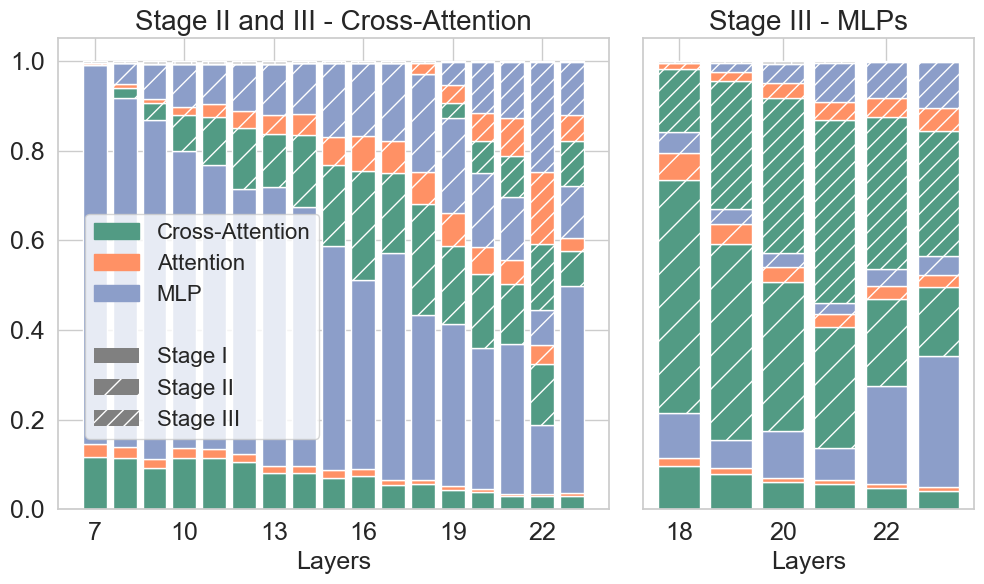

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D



sns.set_theme(style="whitegrid")

plt.rcParams.update({
    'axes.titlesize': 20,      # Column titles
    'axes.labelsize': 18,      # Axis labels
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 16      # Legend text
})

hatches = 3 * [""] + 3 * ["/"] + 3 * ["//"] + ["+"]

x_axis = range(24)

data_2 = data_cr_att

# Colors for each segment
colors_cr = colors + ['lightgrey']
#colors = sns.color_palette("rocket")[2:4] + sns.color_palette("mako")[4:5]


# Create two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [10, 6]})  # 2 rows, 1 column

# Plot data_1 on the first subplot (ax1)
bottom = np.zeros(len(x_axis))[7:24]
for j in range(len(colors_cr)):
    segment_data = [row[j] for row in data_cr_att][7:24]
    # Adjust x-coordinates for spacing
    x_coords = np.arange(len(x_axis), dtype=float)[7:24] # Create x_coords as float array
    #x_coords[4:] += 0.2  # Add spacing after x = 3
    #x_coords[7:] += 0.2  # Add spacing after x = 6
    label = get_label(combis[j]) if j < len(combis) else 'Input 1st Layer'
    ax1.bar(x_coords, segment_data, bottom=bottom, color=colors_cr[j], label=label, width=0.8, hatch=hatches[j])  # Adjust width if needed
    bottom += np.array(segment_data)


ax1.set_xlabel("Layers")

ax1.legend()

# Define subheaders as dummy lines
subheader0 = Line2D([0], [0], color='white', lw=0)
subheader1 = Line2D([0], [0], color='white', lw=0, label="Stage I")  # Invisible line for subtitle
subheader2 = Line2D([0], [0], color='white', lw=0, label="Stage II")
subheader3 = Line2D([0], [0], color='white', lw=0, label="Stage III")



ax1.legend(handles=[
    mpatches.Patch(color=colors_cr[3], hatch="", label="Cross-Attention"),
    mpatches.Patch(color=colors_cr[4], hatch="", label="Attention"),
    mpatches.Patch(color=colors_cr[5], hatch='', label="MLP"),
    subheader0,
    mpatches.Patch(facecolor="grey", hatch=hatches[0], lw=0, edgecolor="white", label="Stage I"),
    mpatches.Patch(facecolor="grey", hatch=hatches[3], lw=0, edgecolor="white", label="Stage II"),
    mpatches.Patch(facecolor="grey", hatch=hatches[6], lw=0, edgecolor="white", label="Stage III"),
    #subheader0,
    #mpatches.Patch(facecolor=colors_cr[9], hatch=hatches[9], lw=0, edgecolor="white", label="Input to 1st Layer")

], loc=(0.05, 0.15))

# Realign x-axis ticks with the bars
ax1.set_xticks([7, 10, 13, 16, 19, 22]) # Set the x ticks to the shifted bar positions
ax1.set_title("Stage II and III - Cross-Attention")

# Plot data_2 on the second subplot (ax2)
bottom = np.zeros(len(x_axis))[18:24]
for j in range(len(colors_cr)):
    segment_data = [row[j] for row in data_mlp][18:24]
    # Adjust x-coordinates for spacing
    x_coords = np.arange(len(x_axis), dtype=float)[18:24] 
    label = get_label(combis[j]) if j < len(combis) else 'Input 1st Layer'
    ax2.bar(x_coords, segment_data, bottom=bottom, color=colors_cr[j], label=label, width=0.8, hatch=hatches[j])  
    bottom += np.array(segment_data)

ax2.set_xlabel("Layers")
ax2.set_title("Stage III - MLPs")

# Realign x-axis ticks with the bars
ax2.set_yticks([]) # Set the x ticks to the shifted bar positions
ax2.set_yticklabels([]) # Set the x tick labels to the original x_axis values


plt.tight_layout()  # Adjust spacing between subplots

plt.savefig("final_plots/cr_attn_neuron_reading_10k.pdf") 
plt.show()

In [211]:
fig.savefig("final_plots/cr_neuron_10k_t5large.pdf") 


### Additional Plot along all Layers

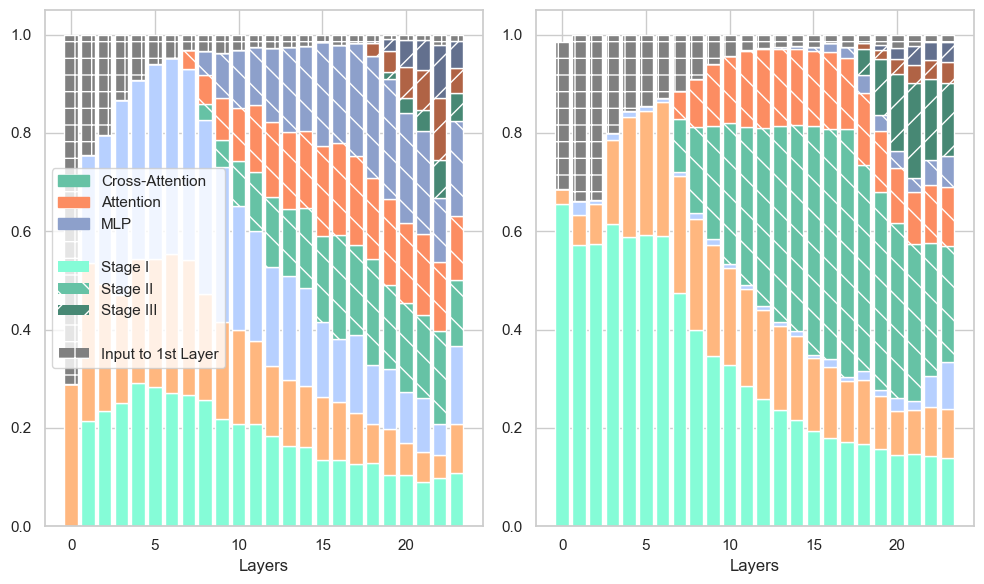

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D


sns.set_theme(style="whitegrid")

hatches = 3 * [""] + 3 * ["\\"] + 3 * ["/"] + ["+"]

x_axis = range(24)

data_2 = data_cr_att

# Colors for each segment
colors_cr = colors + ['grey']


# Create two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # 2 rows, 1 column

# Plot data_1 on the first subplot (ax1)
bottom = np.zeros(len(x_axis))
for j in range(len(colors_cr)):
    segment_data = [row[j] for row in data_cr_att]
    # Adjust x-coordinates for spacing
    x_coords = np.arange(len(x_axis), dtype=float) # Create x_coords as float array

    label = get_label(combis[j]) if j < len(combis) else 'Input 1st Layer'
    ax1.bar(x_coords, segment_data, bottom=bottom, color=colors_cr[j], label=label, width=0.8, hatch=hatches[j])  # Adjust width if needed
    bottom += np.array(segment_data)

ax1.set_xlabel("Layers")
ax1.legend()

# Define subheaders as dummy lines
subheader0 = Line2D([0], [0], color='white', lw=0)
subheader1 = Line2D([0], [0], color='white', lw=0, label="Stage I")  # Invisible line for subtitle
subheader2 = Line2D([0], [0], color='white', lw=0, label="Stage II")
subheader3 = Line2D([0], [0], color='white', lw=0, label="Stage III")


ax1.legend(handles=[
    mpatches.Patch(color=colors_cr[3], hatch="", label="Cross-Attention"),
    mpatches.Patch(color=colors_cr[4], hatch="", label="Attention"),
    mpatches.Patch(color=colors_cr[5], hatch='', label="MLP"),
    subheader0,
    mpatches.Patch(facecolor=colors_cr[0], hatch=hatches[0], lw=0, edgecolor="white", label="Stage I"),
    mpatches.Patch(facecolor=colors_cr[3], hatch=hatches[3], lw=0, edgecolor="white", label="Stage II"),
    mpatches.Patch(facecolor=colors_cr[6], hatch=hatches[6], lw=0, edgecolor="white", label="Stage III"),
    subheader0,
    mpatches.Patch(facecolor=colors_cr[9], hatch=hatches[9], lw=0, edgecolor="white", label="Input to 1st Layer")

])


# Plot data_2 on the second subplot (ax2)
bottom = np.zeros(len(x_axis))
for j in range(len(colors_cr)):
    segment_data = [row[j] for row in data_mlp]
    # Adjust x-coordinates for spacing
    x_coords = np.arange(len(x_axis), dtype=float) # Create x_coords as float array

    label = get_label(combis[j]) if j < len(combis) else 'Input 1st Layer'
    ax2.bar(x_coords, segment_data, bottom=bottom, color=colors_cr[j], label=label, width=0.8, hatch=hatches[j])  # Adjust width if needed
    bottom += np.array(segment_data)

ax2.set_xlabel("Layers")


plt.tight_layout()  # Adjust spacing between subplots
plt.show()